In [1]:
%cd ../..
%reload_ext autoreload
%autoreload 2

/mnt/d/ownCloud/Uni/Semester Ma 5/Advanced Deep Learning for Robotics (IN2349)/Project/tum-adlr-ws20-9


In [2]:
import pyspiel
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm
from itertools import combinations

from alpha_one.model.model_manager import OpenSpielCheckpointManager, AlphaOneCheckpointManager, CFRCheckpointManager
from alpha_one.model.agent import IIGMCTSAgent, DMCTSAgent, OmniscientAgent, DirectInferenceAgent, RandomAgent, HybridAlphaOneDMCTSAgent, CFRAgent
from alpha_one.model.evaluation.agent import AgentEvaluator 
from alpha_one.metrics import AverageRewardRatingSystem, EloRatingSystem, TrueSkillRatingSystem
from alpha_one.train import MCTSConfig
from alpha_one.utils.state_to_value import state_to_value
from alpha_one.utils.mcts_II import initialize_bot_alphaone, ii_mcts_agent, IIGMCTSConfig
from alpha_one.utils.play import GameMachine
from alpha_one.utils.determinized_mcts import initialize_bot, compute_mcts_policy
from alpha_one.game.information_set import InformationSetGenerator
from alpha_one.plots import PlotManager

Instructions for updating:
non-resource variables are not supported in the long term


# 1. Game Setup

In [3]:
game_name = "leduc_poker"
game = pyspiel.load_game(game_name)


# 2. Setup agents

In [225]:
UCT_C = 10000
max_mcts_simulations = 100

## 2.1. AlphaOne
LP-local-43 with checkpoint 15 seems to be good!

In [226]:
run_name_alpha_one = "LP-local-46"

In [227]:
n_previous_observations = 3
optimism = 0.001

In [228]:
model_manager_alpha_one = AlphaOneCheckpointManager(game_name, run_name_alpha_one)

observation_model, game_model = model_manager_alpha_one.load_checkpoint(-1)
observation_model_untrained, game_model_untrained = model_manager_alpha_one.load_checkpoint(0)

INFO:tensorflow:Restoring parameters from /home/tobias/Uni/Semester Ma 5/Advanced Deep Learning for Robotics (IN2349)/Project/model_saves/leduc_poker/LP-local-46-observation_model/checkpoint-19
INFO:tensorflow:Restoring parameters from /home/tobias/Uni/Semester Ma 5/Advanced Deep Learning for Robotics (IN2349)/Project/model_saves/leduc_poker/LP-local-46-game_model/checkpoint-19
INFO:tensorflow:Restoring parameters from /home/tobias/Uni/Semester Ma 5/Advanced Deep Learning for Robotics (IN2349)/Project/model_saves/leduc_poker/LP-local-46-observation_model/checkpoint-0
INFO:tensorflow:Restoring parameters from /home/tobias/Uni/Semester Ma 5/Advanced Deep Learning for Robotics (IN2349)/Project/model_saves/leduc_poker/LP-local-46-game_model/checkpoint-0


In [229]:
alphaone_mcts_config = IIGMCTSConfig(
    uct_c=UCT_C, 
    max_mcts_simulations=max_mcts_simulations,
    temperature=1,
    alpha_one=True, 
    state_to_value=state_to_value(game_name), 
    use_reward_policy=True, 
    n_previous_observations=n_previous_observations, 
    optimism=optimism)

alpha_one_agent = IIGMCTSAgent.from_config(game, observation_model, game_model, alphaone_mcts_config)
alpha_one_agent_untrained = IIGMCTSAgent.from_config(game, observation_model_untrained, game_model_untrained, alphaone_mcts_config)

## 2.2. D-MCTS

In [98]:
run_name_d_mcts = "LP-DMCTS"

In [99]:
model_manager_dmcts = OpenSpielCheckpointManager(game_name, run_name_d_mcts)

dmcts_model = model_manager_dmcts.load_checkpoint(-1)
dmcts_model_untrained = model_manager_dmcts.load_checkpoint(0)

INFO:tensorflow:Restoring parameters from /home/tobias/Uni/Semester Ma 5/Advanced Deep Learning for Robotics (IN2349)/Project/model_saves/leduc_poker/LP-DMCTS/checkpoint-12
INFO:tensorflow:Restoring parameters from /home/tobias/Uni/Semester Ma 5/Advanced Deep Learning for Robotics (IN2349)/Project/model_saves/leduc_poker/LP-DMCTS/checkpoint-0


In [100]:
dmcts_mcts_config = MCTSConfig(uct_c=math.sqrt(2), 
                               max_mcts_simulations=100,
                               temperature=0,
                               determinized_MCTS=True, 
                               omniscient_observer=True,
                               use_reward_policy=True)

d_mcts_agent = DMCTSAgent(dmcts_model, dmcts_mcts_config)
d_mcts_agent_untrained = DMCTSAgent(dmcts_model_untrained, dmcts_mcts_config)
d_mcts_random_rollout_agent = DMCTSAgent(None, dmcts_mcts_config, n_rollouts=1)

## 2.3. Omniscient Agent

In [101]:
run_name_omniscient = "LP-12"

In [102]:
model_manager_omniscient = OpenSpielCheckpointManager(game_name, run_name_omniscient)

omniscient_model = model_manager_omniscient.load_checkpoint(-1)

INFO:tensorflow:Restoring parameters from /home/tobias/Uni/Semester Ma 5/Advanced Deep Learning for Robotics (IN2349)/Project/model_saves/leduc_poker/LP-12/checkpoint-6


In [103]:
omniscient_mcts_config = MCTSConfig(UCT_C, max_mcts_simulations, 0, use_reward_policy=True, omniscient_observer=True)

omniscient_agent_untrained = OmniscientAgent(game, omniscient_mcts_config)
omniscient_agent = OmniscientAgent(game, omniscient_mcts_config, model=omniscient_model)

## 2.4. Blind Agent

In [104]:
run_name_blind = "LP-12-blind-1"

In [105]:
model_manager_blind = OpenSpielCheckpointManager(game_name, run_name_blind)

blind_model = model_manager_blind.load_checkpoint(-1)

INFO:tensorflow:Restoring parameters from /home/tobias/Uni/Semester Ma 5/Advanced Deep Learning for Robotics (IN2349)/Project/model_saves/leduc_poker/LP-12-blind-1/checkpoint-999


In [106]:
blind_agent = DirectInferenceAgent(blind_model)

## 2.5. Random Agent

In [107]:
random_agent = RandomAgent(game)

## 2.6. Hybrid AlphaOne + D-MCTS (Requires 2.1. and 2.2.)

In [108]:
hybrid_alpha_one_dmcts_agent = HybridAlphaOneDMCTSAgent(dmcts_model, observation_model, dmcts_mcts_config, state_to_value(game_name), n_previous_observations)

## 2.7. Hybrid AlphaOne + Omniscient (Requires 2.1. and 2.3.)

In [109]:
hybrid_alpha_one_omniscient_agent = IIGMCTSAgent.from_config(game, observation_model, omniscient_model, alphaone_mcts_config)

## 2.8. Hybrid D-MCTS + Omniscient (Requires 2.2 and 2.3)

In [21]:
hybrid_d_mcts_omniscient_agent = DMCTSAgent(omniscient_model, dmcts_mcts_config)

## 2.9. Super Hybrid (D-MCTS + Omniscient + AlphaOne)

In [22]:
super_hybrid_agent = HybridAlphaOneDMCTSAgent(omniscient_model, observation_model, dmcts_mcts_config, state_to_value(game_name), n_previous_observations)

## 2.10. Counterfactual Regret Minimization

In [23]:
run_name_cfr = 'LP-CFR-2'

In [24]:
model_manager = CFRCheckpointManager(game_name, run_name_cfr)
cfr_policy_table = model_manager.load_checkpoint(-1)
cfr_agent = CFRAgent(cfr_policy_table, temperature=0)

# 3. Player Setup

Available Agents:
 - `alpha_one_agent`
 - `alpha_one_agent_untrained`
 - `d_mcts_agent`
 - `d_mcts_agent_untrained`
 - `d_mcts_random_rollout_agent`
 - `omniscient_agent`
 - `omniscient_agent_untrained`
 - `blind_agent`
 - `random_agent`
 - `hybrid_alpha_one_dmcts_agent`
 - `hybrid_alpha_one_omniscient_agent`
 - `hybrid_d_mcts_omniscient_agent`
 - `cfr_agent`

In [230]:
player_setup = {
    0: alpha_one_agent,
    1: d_mcts_agent,
}

# 4.  Competition with 2 players

In [231]:
game_machine = GameMachine(game)

In [232]:
correct_guess = 0
incorrect_guess = 0
game_returns = []
for _ in tqdm(range(50)):
    game_machine.new_game()

    while not game_machine.is_finished():
        player = game_machine.current_player()
        agent = player_setup[player]
        
        if agent.is_information_set_agent():
            action, policy = agent.next_move(game_machine.get_information_set_generator())
        else:
            action, policy = agent.next_move(game_machine.get_state())
            
        #action = np.argmax(policy)
        if isinstance(agent, IIGMCTSAgent):
            guessed_state = agent.get_last_guessed_state()
            if guessed_state.__str__() == game_machine.state.__str__():
                correct_guess += 1
            else:
                incorrect_guess += 1
    
        game_machine.play_action(action)
            
    game_returns.append(game_machine.get_rewards())
            
            

100%|██████████| 50/50 [02:51<00:00,  3.43s/it]


In [233]:
game_returns = np.array(game_returns)
average_return = game_returns.mean(axis=0)
print(f"Average return:")
print(f"---------------")
print(f"  {type(player_setup[0]).__name__}: {average_return[0]}")
print(f"  {type(player_setup[1]).__name__}: {average_return[1]}")
if correct_guess + incorrect_guess > 0:
    print(f" correct guess probability: {correct_guess/(correct_guess+incorrect_guess):0.2%}")

Average return:
---------------
  IIGMCTSAgent: -1.44
  DMCTSAgent: 1.44
 correct guess probability: 23.28%


# 5. The Tournament of Tournaments

In [234]:
agents = {
    alpha_one_agent: 'AlphaOne',
    alpha_one_agent_untrained: 'AlphaOne untrained',
    d_mcts_agent: 'D-MCTS',
    d_mcts_agent_untrained: 'D-MCTS untrained',
    d_mcts_random_rollout_agent: 'D-MCTS rollout',
    omniscient_agent: 'Omniscient',
    omniscient_agent_untrained: 'Omniscient untrained',
    blind_agent: 'Blind',
    random_agent: 'Random',
    hybrid_alpha_one_dmcts_agent: 'Hybrid AlphaOne + D-MCTS',
    hybrid_alpha_one_omniscient_agent: 'Hybrid AlphaOne + Omniscient',
    cfr_agent: 'CFR',
    hybrid_d_mcts_omniscient_agent: 'Hybrid D-MCTS + Omniscient',
    super_hybrid_agent: 'Super Hybrid'
}
agents_by_key, agent_names_by_key = zip(*agents.items())

In [235]:
evaluator = AgentEvaluator(game)
elo_rating_system = EloRatingSystem(40)
true_skill_rating_system = TrueSkillRatingSystem()
average_reward_rating_system = AverageRewardRatingSystem()
rating_systems = [elo_rating_system, true_skill_rating_system, average_reward_rating_system]

elo_ratings_history = []
true_skill_ratings_history = []
average_reward_ratings_history = []
ratings_histories = [elo_ratings_history, true_skill_ratings_history, average_reward_ratings_history]

rating_system_names = ['Elo Rating', 'TrueSkill Rating', 'Average Reward Rating']

In [236]:
def play_match(agent_id_player_1, agent_id_player_2):
    match_outcome, trajectory = evaluator.evaluate(agents_by_key[agent_id_player_1], agents_by_key[agent_id_player_2])
    match_outcome.with_renamed_players({0: agent_id_player_1, 1: agent_id_player_2})
    return match_outcome

1 Matchday takes around 3 minutes

In [237]:
n_match_days = 5
for _ in tqdm(range(n_match_days)):
    match_outcomes = []
    for agent_id_1, agent_id_2 in combinations(range(len(agents)), 2):
        match_outcomes.append(play_match(agent_id_1, agent_id_2))
        match_outcomes.append(play_match(agent_id_2, agent_id_1))
            
    for rating_system, ratings_history in zip(rating_systems, ratings_histories):
        rating_system.update_ratings(match_outcomes)
        ratings_history.append(rating_system.get_ratings())

100%|██████████| 5/5 [21:52<00:00, 262.51s/it]


# 6. Plot Results

In [238]:
plot_manager = PlotManager.new_run(game_name, 'tournament')

In [239]:
plot_manager.save(elo_rating_system.get_ratings(), 'elo_ratings')
plot_manager.save(true_skill_rating_system.get_ratings(), 'true_skill_ratings')
plot_manager.save(average_reward_rating_system.get_ratings(), 'average_reward_ratings')
#plot_manager.save(ratings_histories, 'ratings_histories')
plot_manager.save(agent_names_by_key, 'agent_names_by_key')

In [244]:
plot_manager = PlotManager(game_name, 'tournament-3')
elo_ratings = plot_manager.load('elo_ratings')
true_skill_ratings = plot_manager.load('true_skill_ratings')
average_reward_ratings = plot_manager.load('average_reward_ratings')
agent_names_by_key = plot_manager.load('agent_names_by_key')

In [245]:
colors = [0, 0, 1, 1, 1, 2, 2, 3, 4, 1, 0, 7, 8, 8]
line_style_config = {
    1: '-',
    2: '--',
    3: '-.',
    4: ':'
}
line_styles = [line_style_config[colors[:idx + 1].count(c)] for idx, c in enumerate(colors)]

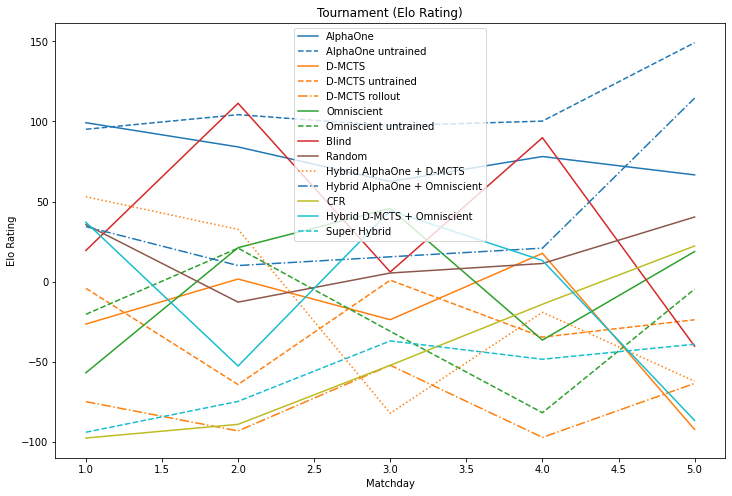

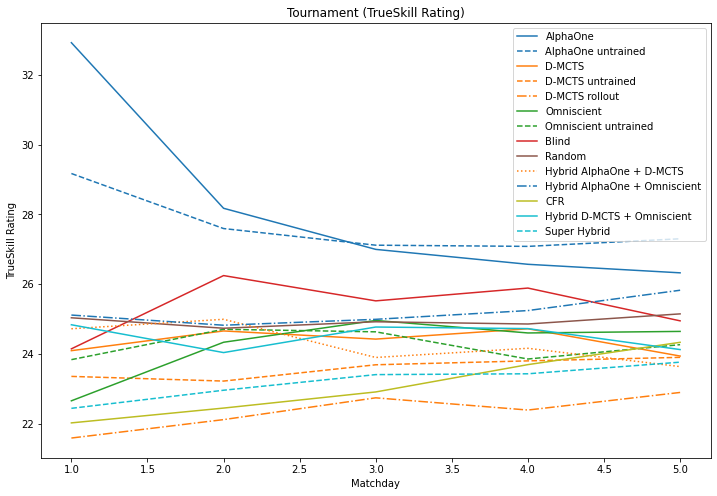

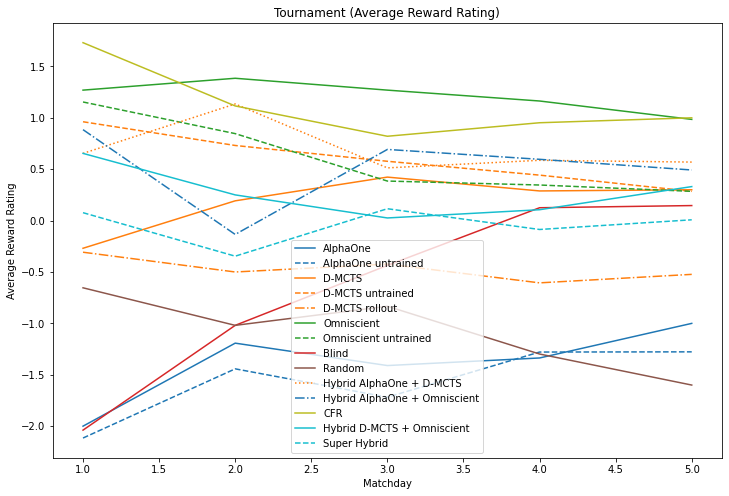

In [241]:
for rating_system, ratings_history, rating_system_name in zip(rating_systems, ratings_histories, rating_system_names):
    plt.figure(figsize=(12, 8))
    color_map = plt.cm.tab10(np.linspace(0,1,max(colors) + 1))
    plt.title(f"Tournament ({rating_system_name})")
    for player_id in range(len(agents)):
        plt.plot(range(1, len(ratings_history) + 1), [rating[player_id] for rating in ratings_history], label=agent_names_by_key[player_id], color=color_map[colors[player_id]], linestyle=line_styles[player_id])
    plt.legend()
    plt.xlabel("Matchday")
    plt.ylabel(rating_system_name)
    plot_manager.save_current_plot(f"tournament_{rating_system_name}.pdf")
    plt.show()

In [147]:
agent_names_by_key

('AlphaOne',
 'AlphaOne untrained',
 'D-MCTS',
 'D-MCTS untrained',
 'D-MCTS rollout',
 'Omniscient',
 'Omniscient untrained',
 'Blind',
 'Random',
 'Hybrid AlphaOne + D-MCTS',
 'Hybrid AlphaOne + Omniscient',
 'CFR',
 'Hybrid D-MCTS + Omniscient',
 'Super Hybrid')

In [246]:
agent_names_sorted = ['AlphaOne untrained', 'AlphaOne', 'Hybrid AlphaOne + Omniscient', 'D-MCTS untrained', 'D-MCTS', 'D-MCTS rollout', 'Hybrid AlphaOne + D-MCTS',  'Hybrid D-MCTS + Omniscient', 'Super Hybrid', 'Omniscient', 'Blind', 'CFR', 'Random']
agent_order = [agent_names_by_key.index(agent_name) for agent_name in agent_names_sorted]

In [248]:
print("Final average rewards:")
#average_rewards = average_reward_rating_system.get_ratings()
average_rewards = average_reward_ratings
average_rewards = sorted(average_rewards.items(), key=lambda x: x[1], reverse=True)
sorted_agents, _ = zip(*average_rewards)
for player_id in sorted_agents:
    #print(f" - {agent_names_by_key[player_id]}: {average_reward_rating_system.get_rating(player_id):.2f}")
    print(f" - {agent_names_by_key[player_id]}: {average_reward_ratings[player_id]:.2f}")

Final average rewards:
 - Omniscient untrained: 1.02
 - Omniscient: 0.84
 - CFR: 0.42
 - D-MCTS untrained: 0.29
 - D-MCTS: 0.22
 - Hybrid D-MCTS + Omniscient: 0.13
 - Hybrid AlphaOne + D-MCTS: 0.07
 - Super Hybrid: 0.05
 - D-MCTS rollout: 0.05
 - Hybrid AlphaOne + Omniscient: 0.04
 - AlphaOne: -0.05
 - Blind: -0.90
 - AlphaOne untrained: -0.95
 - Random: -1.23


In [249]:
win_probability_matrix = np.zeros((len(agents), len(agents)))
for agent_1 in range(len(agents)):
    for agent_2 in range(len(agents)):
        #win_probability_matrix[agent_1, agent_2] = elo_rating_system.calculate_win_probability(elo_rating_system.get_rating(agent_1), elo_rating_system.get_rating(agent_2))
        win_probability_matrix[agent_1, agent_2] = elo_rating_system.calculate_win_probability(elo_ratings[agent_1], elo_ratings[agent_2])
win_probability_matrix = win_probability_matrix[agent_order][:, agent_order]

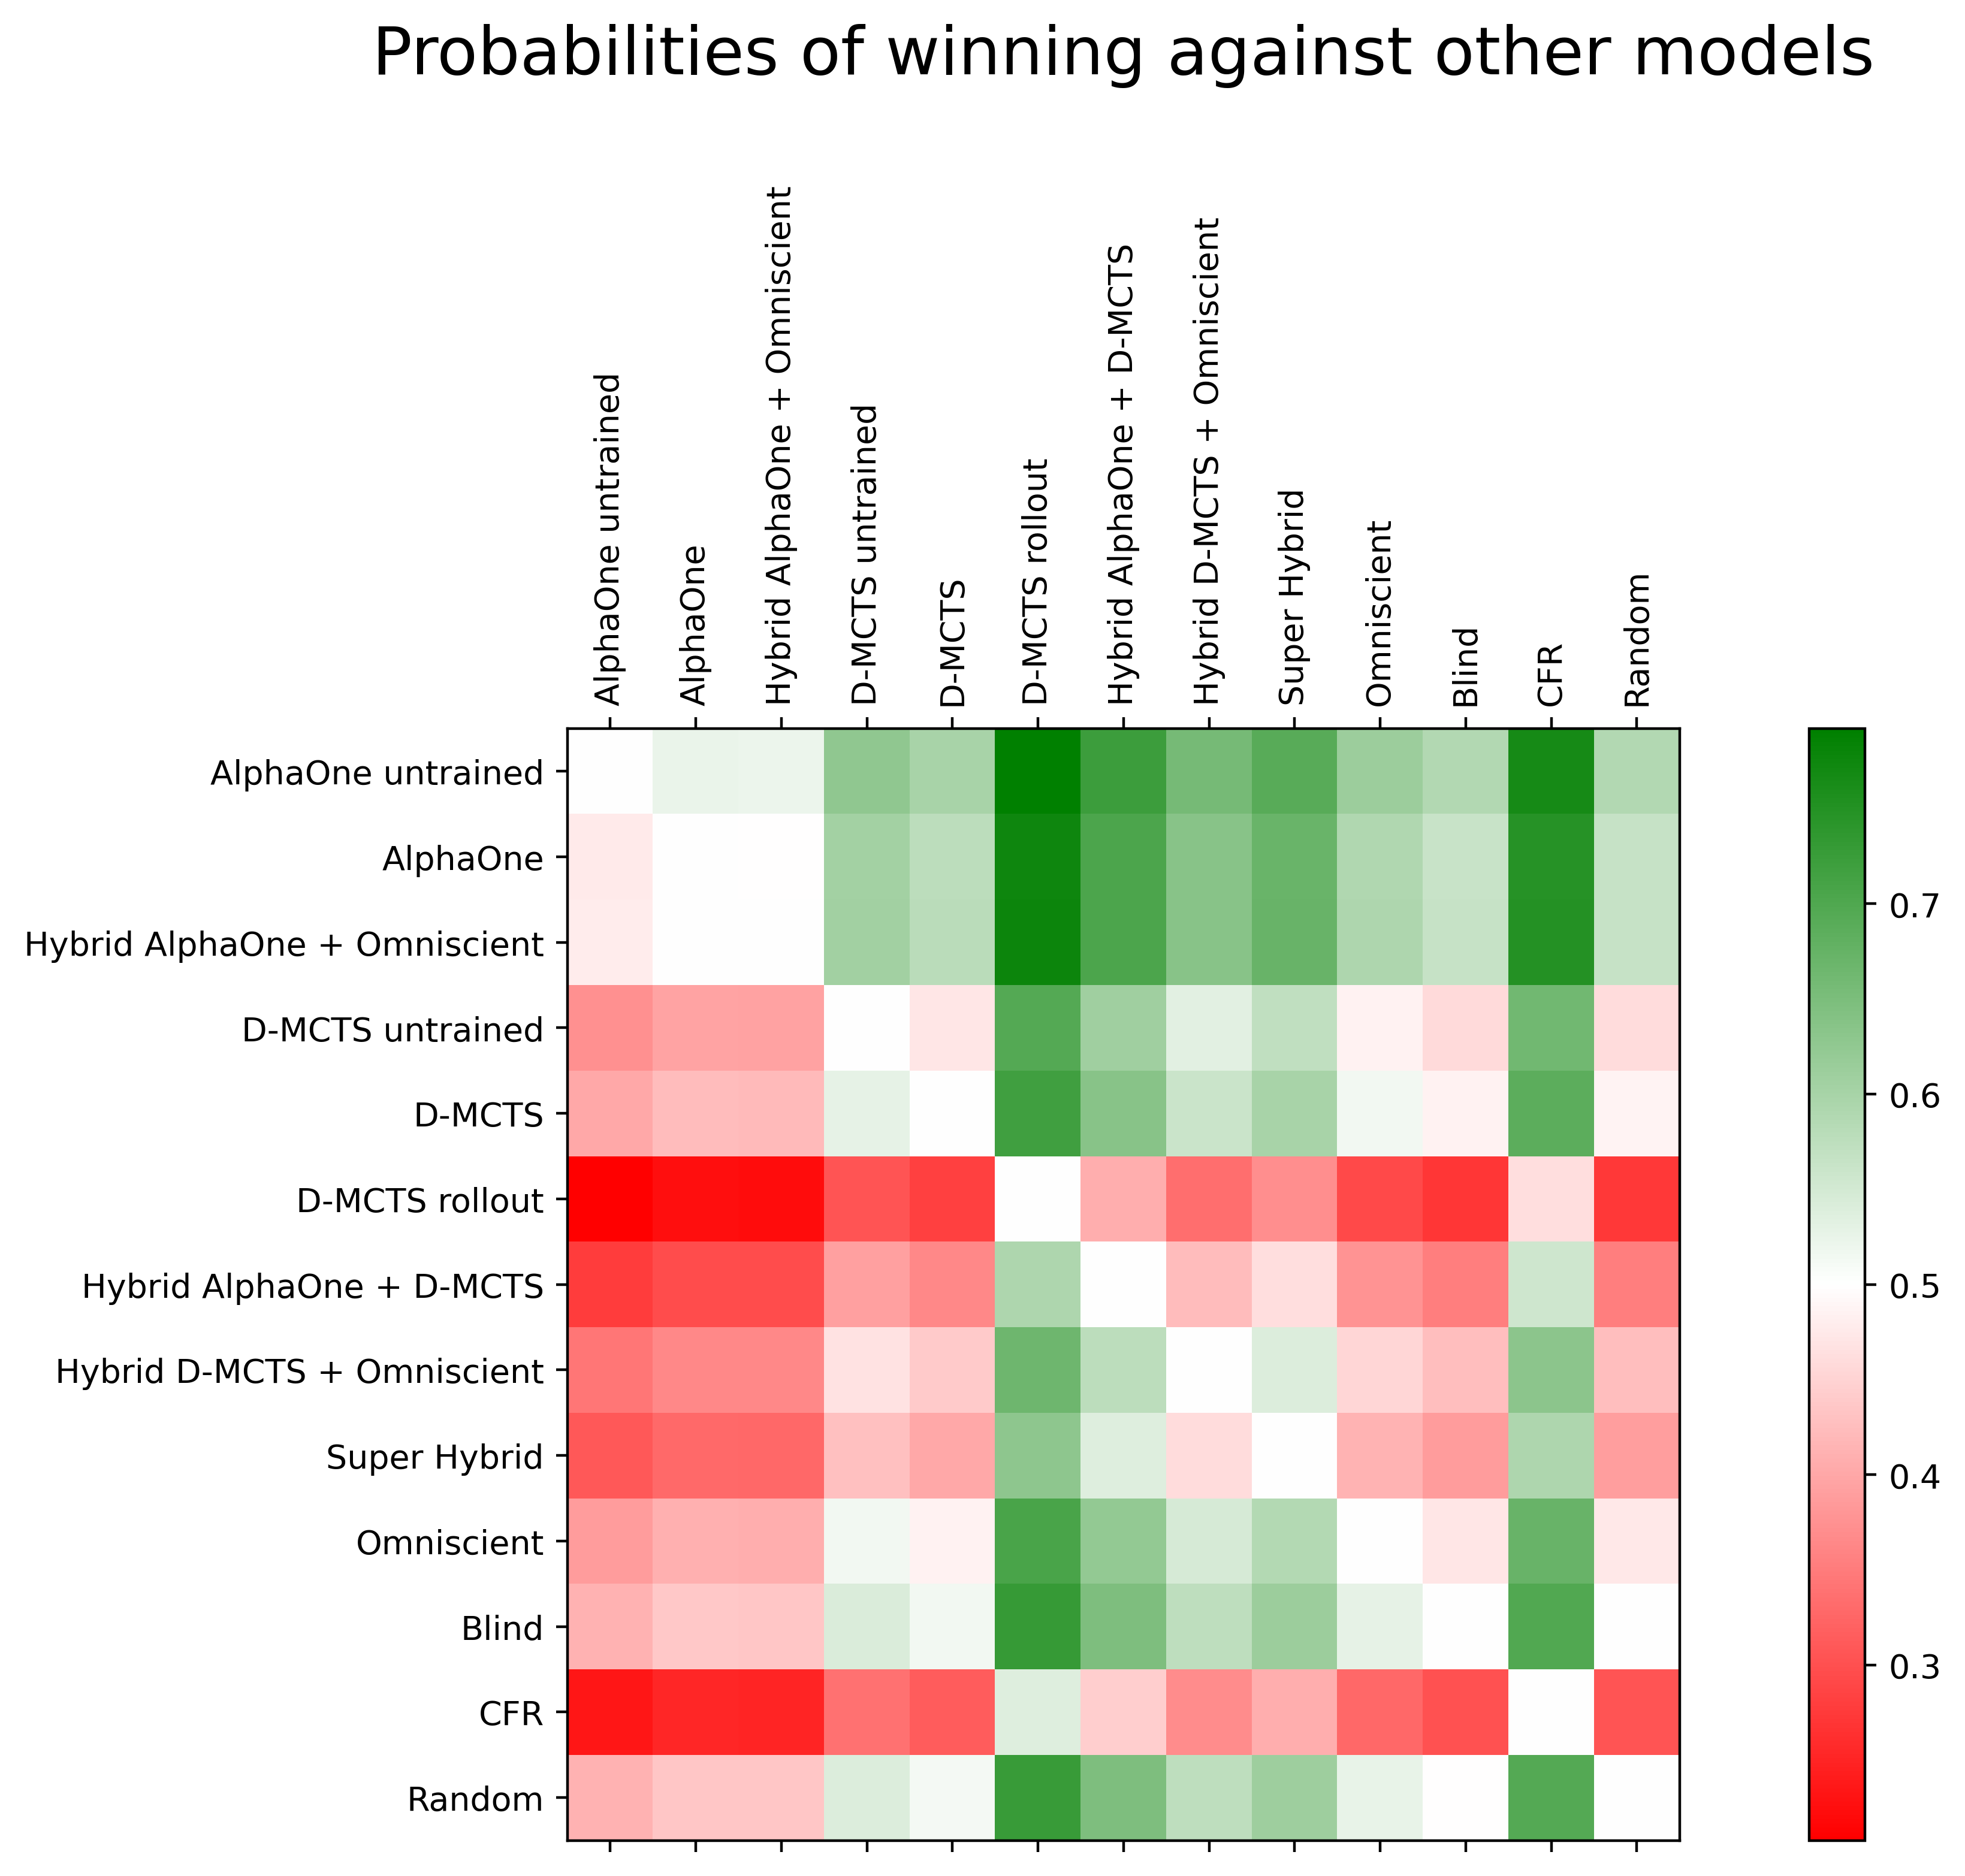

In [265]:
fig = plt.figure(figsize=(12, 8), dpi=400)
ax = plt.gca()
plt.title("Probabilities of winning against other models", pad=180, fontsize=20)
cax = ax.matshow(win_probability_matrix, cmap=matplotlib.colors.LinearSegmentedColormap.from_list("", ["red", "white", "green"]))
ax.set_xticks(list(range(len(agent_names_sorted))))
ax.set_yticks(list(range(len(agent_names_sorted))))
ax.set_xticklabels(agent_names_sorted, rotation=90)
ax.set_yticklabels(agent_names_sorted)
fig.colorbar(cax)
plt.tight_layout()
plot_manager.save_current_plot(f"tournament_winning_probabilities.png")
plt.show()

In [252]:
average_reward_matrix = np.zeros((len(agents), len(agents)))
for agent_1 in range(len(agents)):
    for agent_2 in range(len(agents)):
        #average_reward_matrix[agent_1, agent_2] = average_reward_rating_system.get_rating(agent_1) - average_reward_rating_system.get_rating(agent_2)
        average_reward_matrix[agent_1, agent_2] = average_reward_ratings[agent_1] - average_reward_ratings[agent_2]
average_reward_matrix = average_reward_matrix[agent_order][:, agent_order]

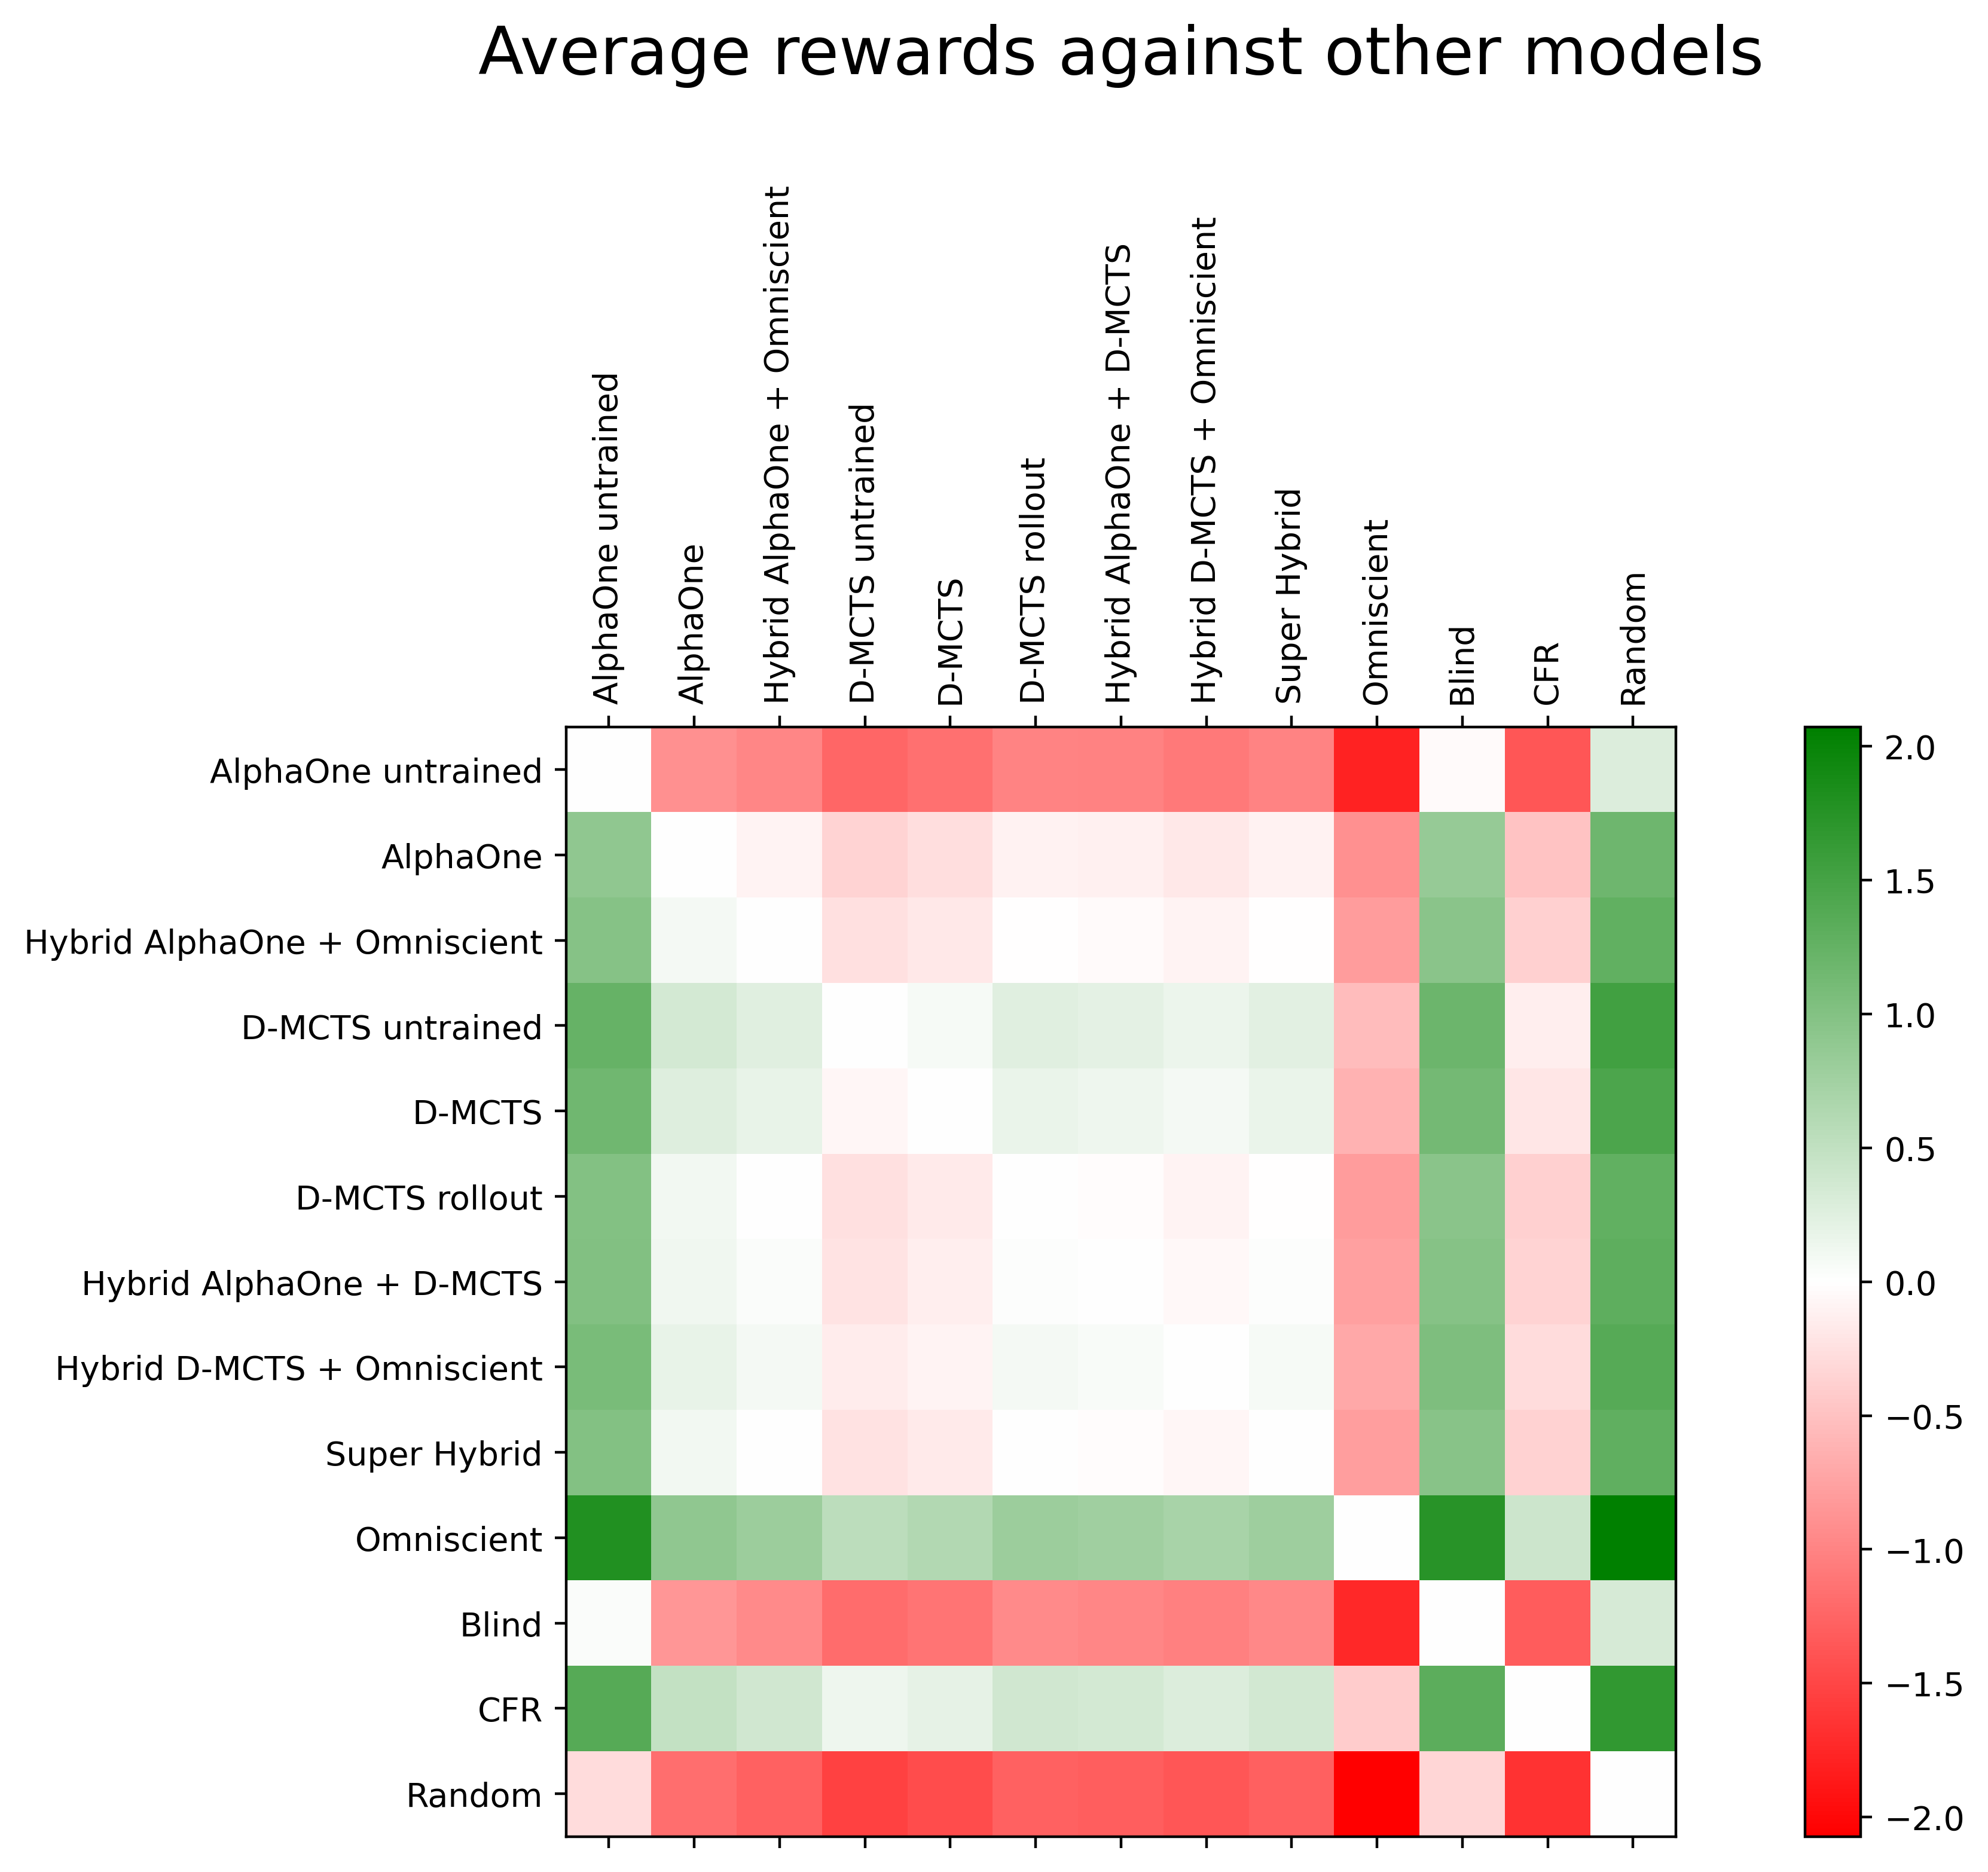

In [266]:
fig = plt.figure(figsize=(12, 8), dpi=400)
ax = plt.gca()
plt.title("Average rewards against other models", pad=180, fontsize=20)
cax = ax.matshow(average_reward_matrix, cmap=matplotlib.colors.LinearSegmentedColormap.from_list("", ["red", "white", "green"]))
ax.set_xticks(list(range(len(agent_names_sorted))))
ax.set_yticks(list(range(len(agent_names_sorted))))
ax.set_xticklabels(agent_names_sorted, rotation=90)
ax.set_yticklabels(agent_names_sorted)
fig.colorbar(cax)
plt.tight_layout()
plot_manager.save_current_plot(f"tournament_average_rewards.png")
plt.show()